# Step-by-step evaluation of fast vertex substitution

Currently the fast vertex substitution local search gets stuck when $\alpha \ge 2$. The algorithm is going to be interactively evaluated step by step with a small instance to try to catch the bug.

## Initial fixed data

In [1]:
from models.instance import Instance
from models.solver import Solver
from models.vertex import Vertex

In [2]:
users = [
    Vertex(0, 5, 80),
    Vertex(1, 43, 34),
    Vertex(2, 22, 70),
    Vertex(3, 80, 10),
    Vertex(4, 9, 11),
    Vertex(5, 60, 75)
]

facilities = [
    Vertex(0, 30, 50),
    Vertex(1, 81, 61),
    Vertex(2, 11, 21),
    Vertex(3, 55, 25)
]

instance = Instance(users, facilities)

- $n = 6$
- $m = 4$
- $p = 3$
- $\alpha = 2$

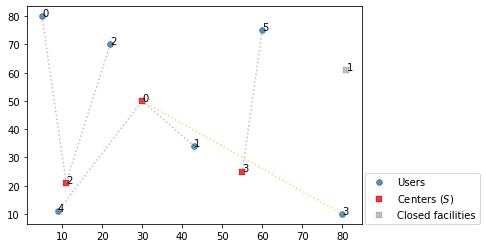

In [3]:
solver = Solver(instance, 3, 2)

solver.solution.open_facilities = {0, 2, 3}
solver.solution.closed_facilities = {1}
solver.allocate_all()
solver.update_obj_func()

solver.plot()

The objective function value, $x$, is:

In [4]:
solver.solution.get_objective_function()

64

The critical allocation determines $x$:

In [5]:
solver.solution.critical_allocation

AllocatedFacility(index=0, user=3, distance=64)

The critical facility $f_*$ is $0$ and the critical user $u_*$ is $3$, and their distance is $x = 64$.

## The algorithm

### Iteration 1

In [6]:
import sys

best_obj_func = sys.maxsize
best_in = -1
best_out = -1

#### Loop closed facilities

In [7]:
solver.solution.closed_facilities

{1}

If facility $1$ is inserted, $f_i = 1$, its distance to $u_*$ would be

In [8]:
fi_distance = solver.instance.get_distance(3, 1)
fi_distance

51

which is less than $x$, $51 < 64$. This means the $x$ can be broken and find a better value, so $f_i$ remains as $1$.

Now let's evaluate `move()`.

##### Find a facility to close or remove from the solution, $f_r$, when $f_i = 1$.

In [9]:
current_of = 0
r = {0:0, 2:0, 3:0}
z = {0:0, 2:0, 3:0}

###### Loop users

In [10]:
solver.instance.users_indexes

{0, 1, 2, 3, 4, 5}

$u = 0$

In [11]:
u_fi_dist = solver.instance.get_distance(0, 1)
u_fi_dist

78

In [12]:
closests = solver.get_alpha_range_closests(0)
closests

{1: AllocatedFacility(index=0, user=0, distance=39),
 2: AllocatedFacility(index=2, user=0, distance=59),
 3: AllocatedFacility(index=3, user=0, distance=74)}

The $\alpha$-th (in this case second, $\alpha = 2$) closest facility of $u$ is index $2$, $f_\alpha(u) = 2$.

$f_i$ is not closer to $u$ than $f_\alpha$:

$d_i > d_\alpha \rightarrow 78 > 59$

So data structures $r$ and $z$ need to be updated by "deleting" $f_\alpha = 2$.

- $r(f_\alpha) \leftarrow \max\{ r(f_\alpha), d_\alpha \}$
- $r(2) \leftarrow \max\{ r(2), d_2 \}$

In [13]:
r[2]

0

In [14]:
closests[2].distance

59

- $r(2) \leftarrow \max\{ 0, 59 \}$

In [15]:
r[2] = 59

- $z(f_\alpha) \leftarrow \max\{ z(f_\alpha), \min\{ d_i, d_{\alpha + 1} \} \}$
- $z(2) \leftarrow \max\{ z(2), \min\{ d_i, d_{3} \} \}$

In [16]:
z[2]

0

In [17]:
u_fi_dist

78

In [18]:
closests[3].distance

74

- $z(2) \leftarrow \max\{ 0, \min\{ 78, 74 \} \}$

In [19]:
min(78, 74)

74

- $z(2) \leftarrow \max\{ 0, 74 \}$

In [20]:
z[2] = 74

Next user $u = 1$

In [21]:
u_fi_dist = solver.instance.get_distance(1, 1)
u_fi_dist

47

In [22]:
closests = solver.get_alpha_range_closests(1)
closests

{2: AllocatedFacility(index=0, user=1, distance=21),
 3: AllocatedFacility(index=2, user=1, distance=35),
 1: AllocatedFacility(index=3, user=1, distance=15)}

In [23]:
closests[2]

AllocatedFacility(index=0, user=1, distance=21)

$f_\alpha = 0$, $d_\alpha = 21$

$d_i > d_\alpha$ so update $r$ and $z$.

In [24]:
r[0]

0

In [25]:
r[0] = 21

In [26]:
z[0]

0

In [27]:
min(47, 35)

35

In [28]:
z[0] = 35

Next user $u = 2$.

In [29]:
u_fi_dist = solver.instance.get_distance(2, 1)
u_fi_dist

60

In [30]:
closests = solver.get_alpha_range_closests(2)
closests

{1: AllocatedFacility(index=0, user=2, distance=22),
 2: AllocatedFacility(index=2, user=2, distance=50),
 3: AllocatedFacility(index=3, user=2, distance=56)}

$60 > 50$ so update $r$ and $z$.

In [31]:
r[2]

59

In [32]:
max(59, 50)

59

$r(2)$ doesn't change.

In [33]:
z[2]

74

In [34]:
min(60, 56)

56

In [35]:
max(74, 56)

74

$z(2)$ doesn't change either.

Next user $u = 3$

In [36]:
u_fi_dist = solver.instance.get_distance(3, 1)
u_fi_dist

51

In [37]:
closests = solver.get_alpha_range_closests(3)
closests

{2: AllocatedFacility(index=0, user=3, distance=64),
 3: AllocatedFacility(index=2, user=3, distance=70),
 1: AllocatedFacility(index=3, user=3, distance=29)}

This $u$ is $u_*$. This is the case that breaks $x$, the reason to enter this current loop, because $d_\alpha(u) = 64$ is $x$, and $d_i = 51$ is less than that.

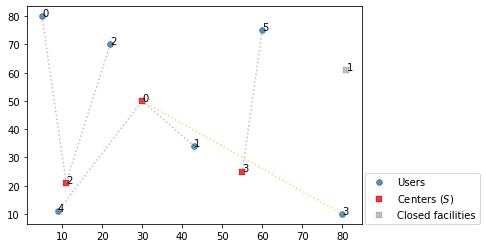

In [38]:
solver.plot()

So update the current objective function $x'$:

- $x' \leftarrow \max\{ x', \max\{ d_i, d_{\alpha - 1} \} \}$

In [39]:
current_of

0

- $x' \leftarrow \max\{ 0, \max\{ 51, 29 \} \}$

In [40]:
max(51, 29)

51

- $x' \leftarrow \max\{ 0, 51 \}$

In [41]:
current_of = 51

Due to $d_i < d_\alpha$, data structures $r$ and $z$ don't get updated.

Next user $u = 4$

In [42]:
u_fi_dist = solver.instance.get_distance(4, 1)
u_fi_dist

88

In [43]:
closests = solver.get_alpha_range_closests(4)
closests

{2: AllocatedFacility(index=0, user=4, distance=44),
 1: AllocatedFacility(index=2, user=4, distance=10),
 3: AllocatedFacility(index=3, user=4, distance=48)}

$88 > 44$ so update $r$ and $z$.

In [44]:
r[0]

21

In [45]:
max(21, 44)

44

In [46]:
r[0] = 44

In [47]:
z[0]

35

In [48]:
min(88, 48)

48

In [49]:
max(35, 48)

48

In [50]:
z[0] = 48

Next user $u = 5$

In [51]:
u_fi_dist = solver.instance.get_distance(5, 1)
u_fi_dist

25

In [52]:
closests = solver.get_alpha_range_closests(5)
closests

{1: AllocatedFacility(index=0, user=5, distance=39),
 3: AllocatedFacility(index=2, user=5, distance=73),
 2: AllocatedFacility(index=3, user=5, distance=50)}

$25 < 50$ so update $x'$

In [53]:
current_of

51

In [54]:
max(25, 39)

39

In [55]:
max(51, 39)

51

$x'$ doesn't change.

###### Find best deletion

All users were compared, let's check the data structures:

In [56]:
current_of

51

In [57]:
r

{0: 44, 2: 59, 3: 0}

In [58]:
z

{0: 48, 2: 74, 3: 0}

The largest distance, $g_1$, and the second largest distance, $g_2$, from $r$ are:

In [59]:
from models.moved_facility import MovedFacility

g1 = MovedFacility(2, 59)
g2 = MovedFacility(0, 44)

Let $j_*$ be the corresponding index of $g_1$: $j_* = 2$.

Find $f_r$:

$$f_r = \min_{j \in S}\{ \max\{ x', z(j), \max_{l \neq j}{r(l)} \} \}$$

Loop open facilities in the solution, $S$, which are also the indexes or keys of $z$ and $r$:

In [60]:
solver.solution.open_facilities

{0, 2, 3}

For $j = 0$, $l \in \{ 2, 3 \}$:

In [61]:
max(59, 0)

59

$r(l) = 59$:

In [62]:
max(51, 48, 59)

59

Now there's a better $f_r = j = 0$ with $x_* = 59$.

In [63]:
fr = MovedFacility(0, 59)

For $j = 2$, $l \in \{0, 3\} $

In [64]:
max(44, 0)

44

In [65]:
max(51, 74, 44)

74

$74 > 59$ so $x_*$ didn't improved and $f_r = 0$ is maintained.

For $j = 3$, $l \in \{0, 2\}$

In [66]:
max(44, 59)

59

In [67]:
max(51, 0, 59)

59

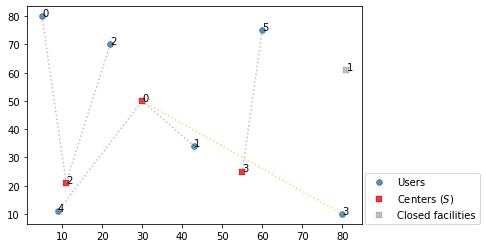

In [70]:
solver.plot()

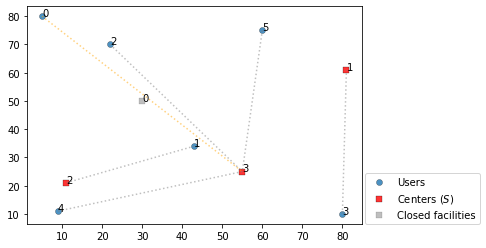

Solution(open_facilities={1, 2, 3}, critical_allocation=AllocatedFacility(index=3, user=0, distance=74))

In [71]:
solver.swap(1, 0)
solver.plot()
solver.solution

In [68]:
solver.instance.distances

[[39, 78, 59, 74],
 [21, 47, 35, 15],
 [22, 60, 50, 56],
 [64, 51, 70, 29],
 [44, 88, 10, 48],
 [39, 25, 73, 50]]

In [69]:
solver.instance.sorted_distances

[[(0, 39), (2, 59), (3, 74), (1, 78)],
 [(3, 15), (0, 21), (2, 35), (1, 47)],
 [(0, 22), (2, 50), (3, 56), (1, 60)],
 [(3, 29), (1, 51), (0, 64), (2, 70)],
 [(2, 10), (0, 44), (3, 48), (1, 88)],
 [(1, 25), (0, 39), (3, 50), (2, 73)]]

The result of inserting $1$ and removing $0$ is totally different of that we should get from data structures $x'$, $r$, and $z$.

It seems like the group of users that are attracted to $f_i$ needs to be split in 2 groups (and data structures):

- Those that $f_\alpha \leftarrow f_i$
- And those that $f_\alpha \leftarrow f_{\alpha - 1}$

Also it seems that because the open facilities closer than $f_\alpha$ determine it, more data structures are needed to store their distances too (currently, for $z$ only $d_\alpha$ and $d_{\alpha + 1}$ are considerated).